In [1]:
from ipynb.fs.full.Functions import *
from sklearn import datasets

## Om de volgende cell te laten werken:
### In final_code.ipynb, run all cells en zet dan dit neer

from sklearn import datasets

data = {'Water level':ssh, "Time":nt, "D1": nd1,"D2": nd2, 'D4': D4Amp}

%store data


### We hebben nog de slome variant van harmfit in deze variant staan, dus dit notebook gaat 219304x sneller als je ff harmfit vervangt door deze: 

def harmfit(invariant, *args):
    # a0, Cn, and Dn are the estimated amplitudes and phases of the constituents
    # wn are the angular frequencies of the consistuents
    # t is the time vector
    # output = mean + sum_k=1^k=Nharm Cn*sin(wn(k)*t) + Dn*cos(wn(k)*t)

    if len(args) == 1:
        args = tuple(args[0])

    t = invariant["timesteps"]
    wn = invariant["wn"]

    in_args = np.array(args[1:])

    a0 = args[0]
    Cn, Dn = np.split(in_args, 2)
    
    ts = np.array(t)
    
    test = np.empty(len(t))
    test.fill(a0)

    for k in range(len(Cn)):
        test = test + Cn[k] * np.sin(wn[k] * ts) + Dn[k] * np.cos(wn[k] * ts)
    return test

In [17]:
%store -r data
print(data)

{'Water level': date_time
2018-01-01 00:10:00    1.051
2018-01-01 00:20:00    0.951
2018-01-01 00:30:00    0.851
2018-01-01 00:40:00    0.751
2018-01-01 00:50:00    0.641
                       ...  
2018-12-31 23:10:00   -0.129
2018-12-31 23:20:00   -0.199
2018-12-31 23:30:00   -0.269
2018-12-31 23:40:00   -0.329
2018-12-31 23:50:00   -0.379
Name: sea_level, Length: 52014, dtype: float64, 'Time': array([datetime.datetime(2018, 1, 1, 12, 31),
       datetime.datetime(2018, 1, 1, 14, 31),
       datetime.datetime(2018, 1, 1, 16, 31), ...,
       datetime.datetime(2018, 12, 30, 6, 20),
       datetime.datetime(2018, 12, 30, 8, 30),
       datetime.datetime(2018, 12, 30, 10, 0)], dtype=object), 'D1': array([0.39576076, 0.35430761, 0.33493093, ..., 0.47463865, 0.52863447,
       0.53837955]), 'D2': array([1.52955773, 1.5389399 , 1.51901142, ..., 1.28008174, 1.21633299,
       1.25017292]), 'D4': array([0.16027708, 0.20437256, 0.30214371, ..., 0.13037891, 0.15103066,
       0.12157026])}


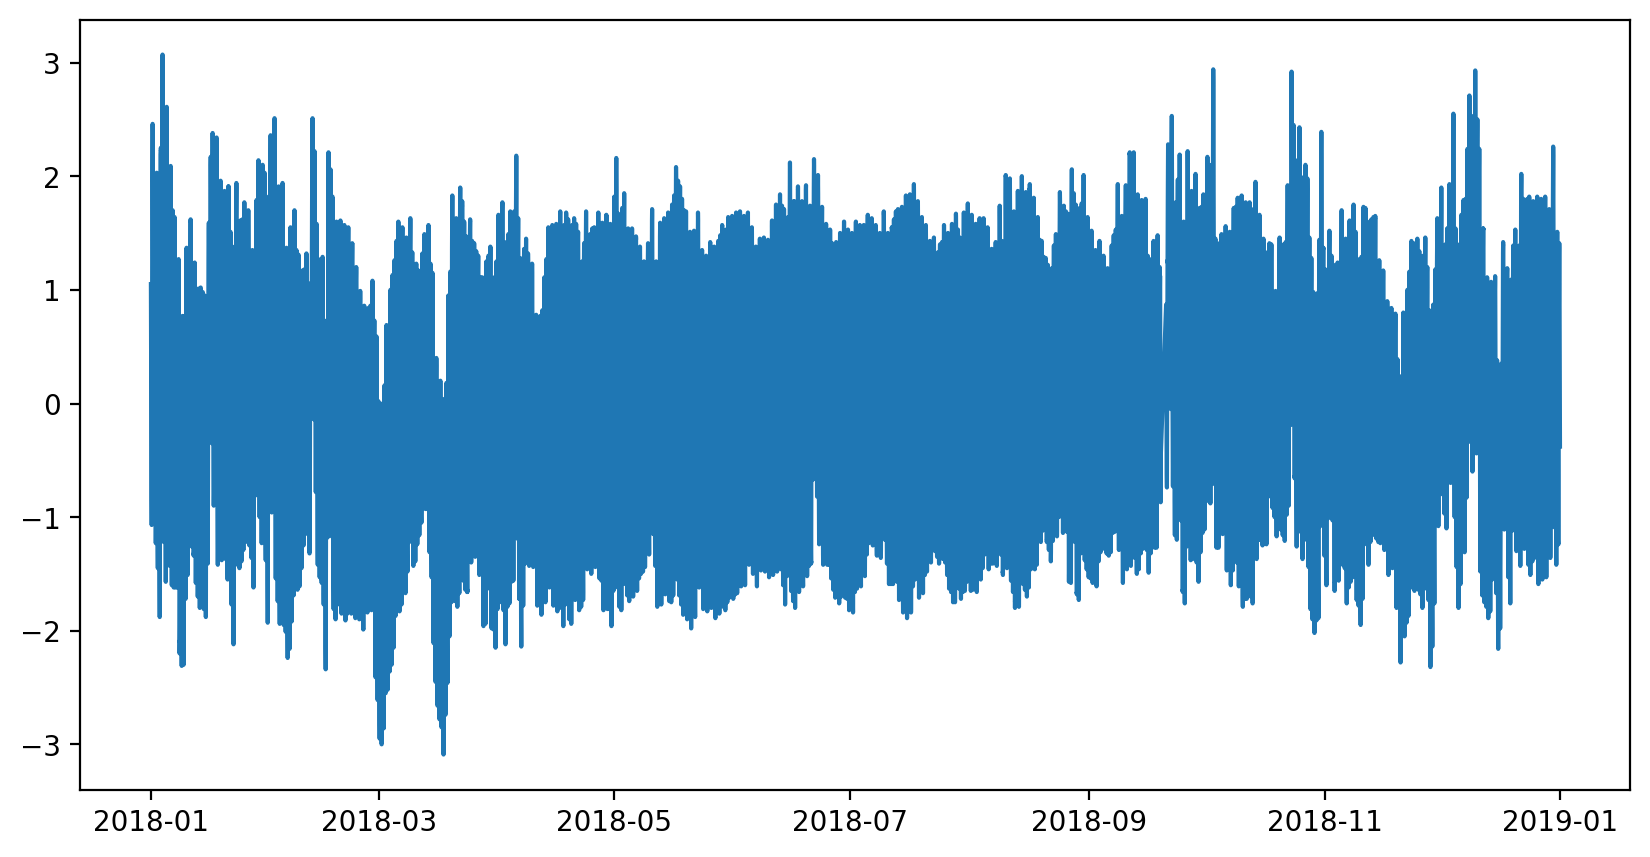

In [4]:
plt.plot(data['Water level'])

In [12]:
def get_Q_arr_elbe(Z= Z, Ws=5e-4, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=np.pi/2, ampD1=0, ampM2=1, ampM4=0.2): #Define amp D1 M2 and M4 in calling function 
    '''
    Function to get time, C and Q. 
    Input:
        Ws = 
        alpha = 
        Kv = 
    Output: 
        t = 
        C = 
        Q = 
    '''

    T = (3600*24)*365  #Total T is number of seconds in a year, because we analyse a year of data
    Tadapt = Kv/Ws**2
    Test = 3*Tadapt          # Estimated adaptation time scale to get to equilibrium C
    Tnt  = np.ceil(Test/T)
    Tend = 3*Tnt*T           # Depends on Ws and Kv. Enough time to Equilibrium C. 
    deltaT = 1819            # Time step of 50 minutes, I got this number because then Hydromodel worked. If you change this you need to interpolate

    t  = np.arange(0, Tend+deltaT, deltaT)
    Nt = len(t)

    dZdt = np.gradient(Z, deltaT)
 
    L  = 28150                     # E-folding length scale
    dx = 10                     # Grid distance. Didn't change it
    x  = np.arange(0, L+dx, dx)  # x-coordinate. Seaward end is at x=L, landward end at x=0. 
    Nx = len(x)                  
    H = 8.67-8e-4 * x             # Eq. Depth
    dHdx = np.ones(Nx) * -8e-4 # Didnt change this. Don't know if we have to

    print(np.shape(t))
    print(np.shape(Z))
    print(np.shape(dZdt))
    print(np.shape(H))
    print(np.shape(dHdx))
    print(np.shape(x))
    print(np.shape(dx))
    
    U = HydroModel(t,Z,dZdt,H,dHdx,x,dx) # Calculating flow velocities 

    Cgroen = np.zeros((Nx, Nt))
    Qsgroen = np.zeros((Nx,Nt))
    
    for px in range(Nx):
        Cgroen[px,0:Nt],Qsgroen[px,0:Nt] = GroenModel(U[px,0:Nt],t,deltaT, T, Ws, alpha, Kv) #using groens model to find C and Q
        
    Nsteps = T/deltaT       # Nr of timesteps in one tidal cycle. #added 
    final_cycle = int(-Nsteps) #added
    meanQsgroen = np.mean(Qsgroen[:,final_cycle:], 1) #added
    
    return t, Cgroen, Qsgroen, U, meanQsgroen

In [23]:
Z_data = data['Water level']
print('Z_data_raw', np.shape(Z_data))
Z_data = Z_data[0:-2] #Spliced like this because otherwise we need to interpolate and didn't feel like that
print('Z_data_spliced', np.shape(Z_data))
t, Cgroen, Qsgroen, U, meanQsgroen = get_Q_arr_elbe(Z=Z_data, Ws=5e-4, alpha=1e-4, Kv=1e-2, phaseD1=0, phaseM2=0, phaseM4=np.pi/2, ampD1=data['D1'],
               ampM2=data['D2'], ampM4=data['D4'])

Z_data_raw (52014,)
Z_data_spliced (52012,)
(52012,)
(52012,)
(52012,)
(2816,)
(2816,)
(2816,)
()


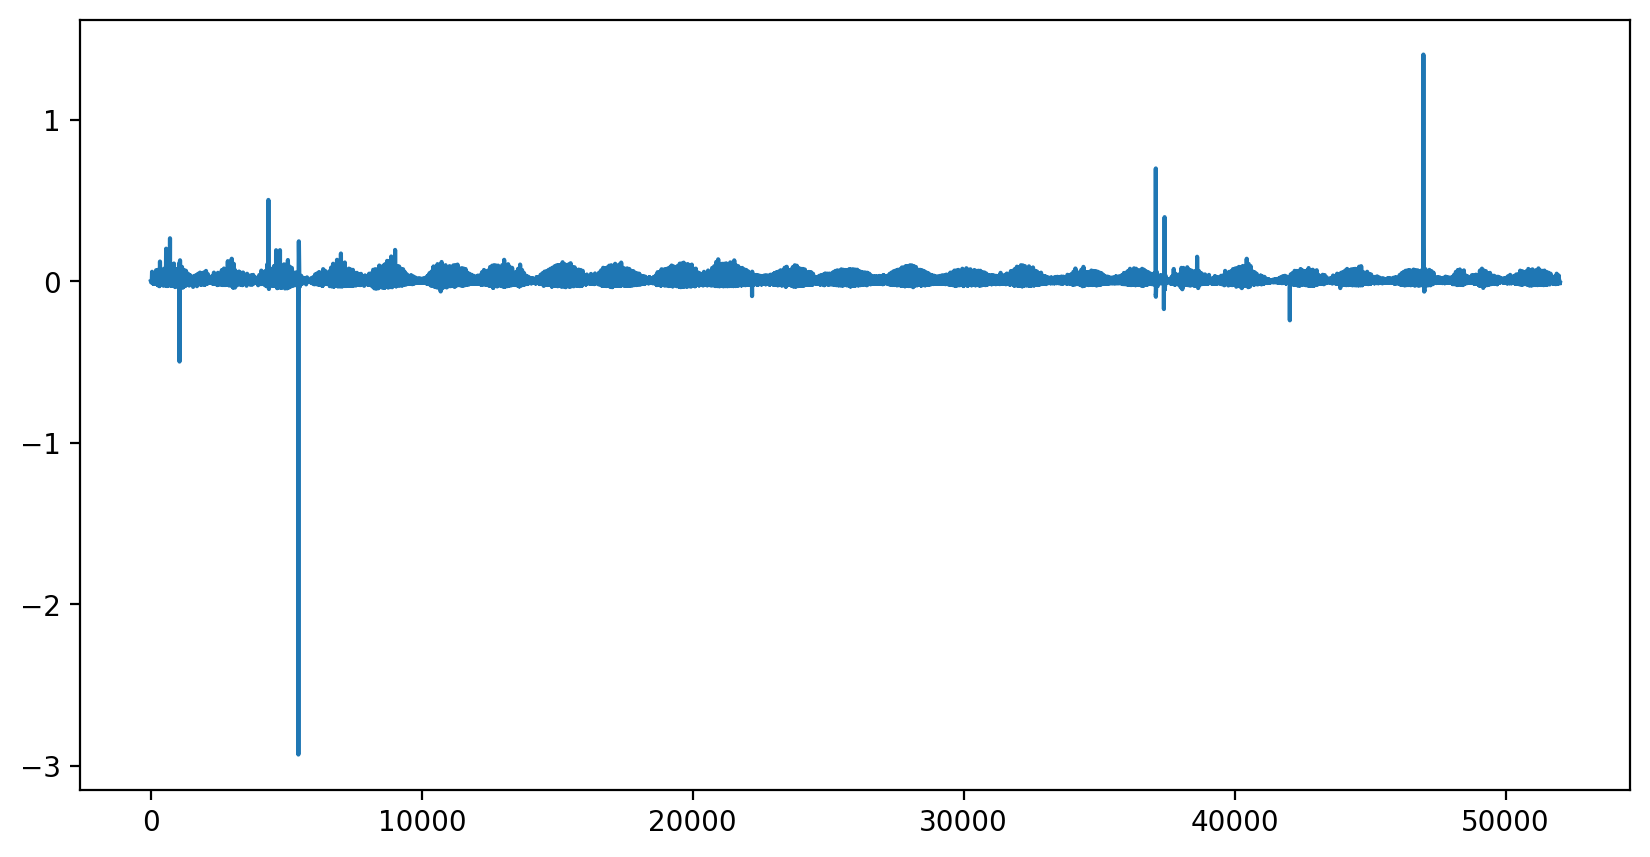

In [29]:
plt.plot(Qsgroen[15])

In [5]:
Kv = 1e-2 #Standard values
Ws = 5e-4 #Standard values

ampD1 = data['D1']  #Amplitudes from ex. 1
ampM2 = data['D2'] #Amplitudes from ex. 1
ampM4 = data['D4'] #Amplitudes from ex. 1
phaseD1 = 0       #For the phases I just put in some random variable
phaseM2 = np.pi/2
PhaseM4 = 0

T = (3600*24)*365 #Total T is number of seconds in a year, because we analyse a year of data

      
Tadapt = Kv/Ws**2         # Didnt change this
Test = 3*Tadapt          # ''
Tnt  = np.ceil(Test/T)   # Didnt change it
Tend = 3*Tnt*T           # Depends on Ws and Kv. Enough time to Equilibrium C. 
deltaT = 1819            # Time step of 50 minutes, I got this number because then Hydromodel worked. If you change this you need to interpolate
t  = np.arange(0, Tend+deltaT, deltaT)
Nt = len(t)
L  = 28150                     # E-folding length scale
dx = 10                     # Grid distance. Didn't change it
x  = np.arange(0, L+dx, dx)  # x-coordinate. Seaward end is at x=L, landward end at x=0. 
Nx = len(x)                  # array of ??? long
H = 10-8e-4 * x             # Didn't change this. Don't know if we have to
dHdx = np.ones(Nx) * -8e-4 # Didnt change this. Don't know if we have to


In [ ]:
Z_data = data['Water level']
Z_data = Z_data[0:-2] #Spliced like this because otherwise we need to interpolate and didn't feel like that
dZdt = np.gradient(Z, deltaT)
U = HydroModel(t,Z,dZdt,H,dHdx,x,dx)

Text(0, 0.5, 'Flow velocity (m/s)')

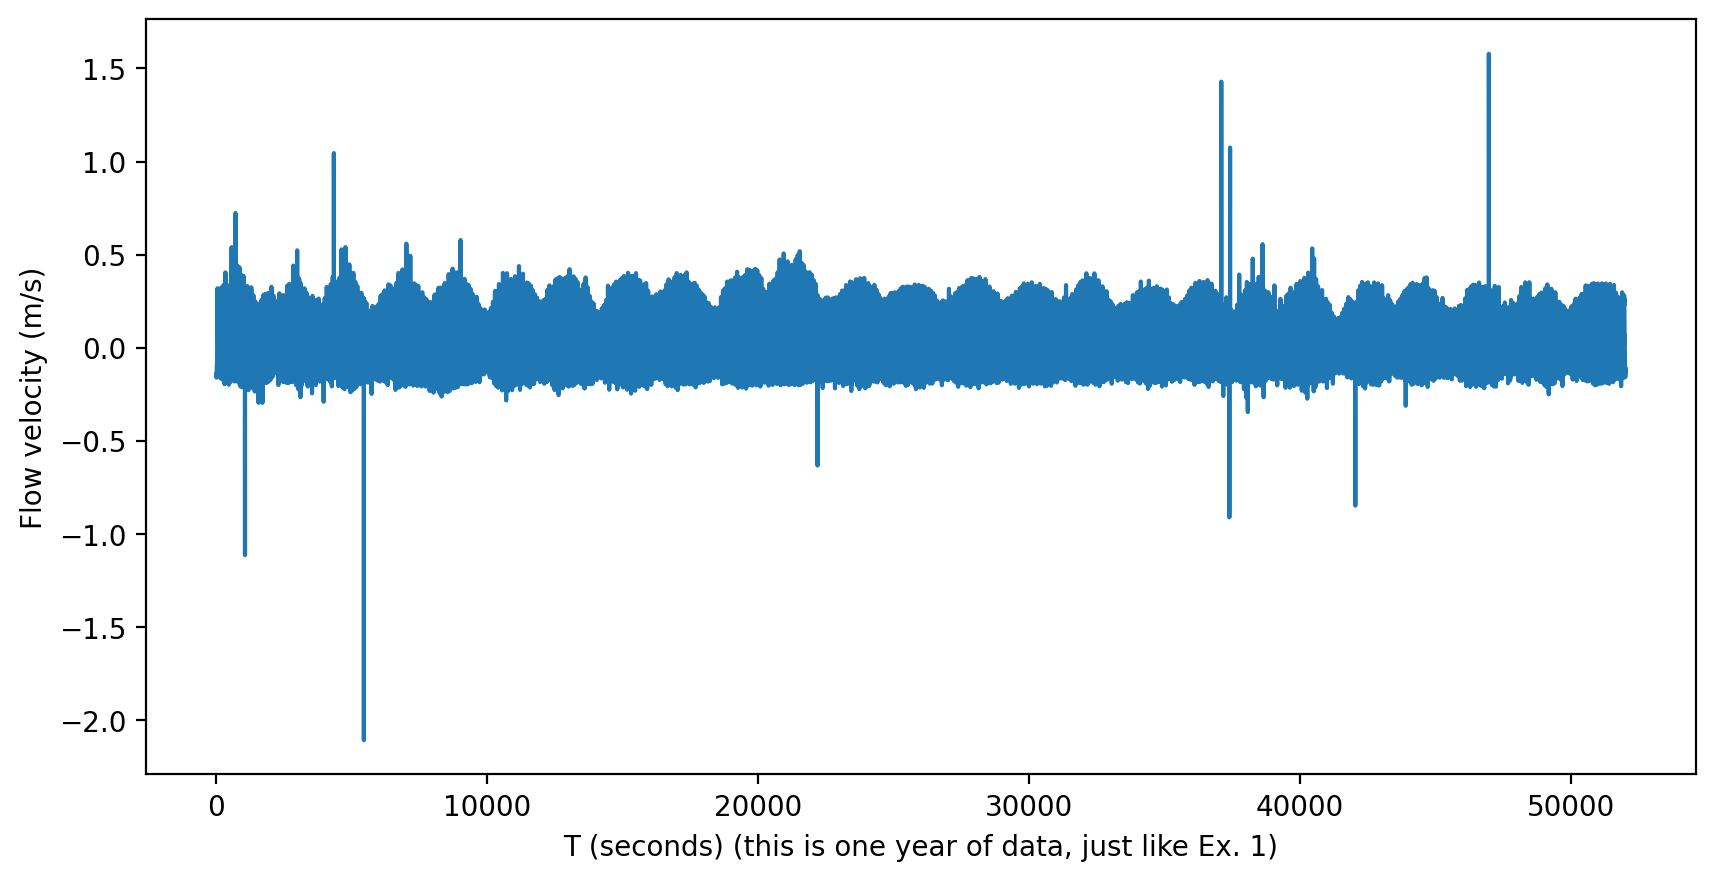

In [59]:
plt.plot(U[0])
plt.xlabel('T (seconds) (this is one year of data, just like Ex. 1)')
plt.ylabel('Flow velocity (m/s)')
# plt.plot(data["Water level"])